In [2]:
import sys
#!{sys.executable} -m pip install easyocr
#!{sys.executable} -m pip install seaborn

# ***Campioniamo 40 report randomicamente***

In [3]:
import os
import random
import shutil
import pandas as pd
import json
import easyocr
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import pytesseract
from tqdm import tqdm
import Levenshtein
import re
import matplotlib.pyplot as plt
import numpy as np
reports_dir = 'IMAGES'
all_reports = os.listdir('IMAGES')
num_reports = len(all_reports)
num_samples = 50
test_samples_dir = 'TEST_SAMPLES'

## Codice per il campionamento

In [ ]:
sampled_reports = []
already_sampled = []
while len(sampled_reports) < num_samples:
    sampled_index = random.randint(0,num_reports-1)
    if sampled_index not in already_sampled:
        sampled_reports.append(all_reports[sampled_index])
        already_sampled.append(sampled_index)

## Salvataggio del campionamento

In [ ]:
#for sample in sampled_reports:
#    path = os.path.join(reports_dir, sample)
#    dest_path = os.path.join(test_samples_dir, sample)
#    shutil.copytree(path, dest_path)

# Creaiamo il dataset di test

In [151]:
test_set = pd.DataFrame()
TCGAs = os.listdir(test_samples_dir)
test_set['SAMPLE'] = TCGAs

In [4]:
#etichettati a mano
ground_truth = {
    'TCGA-A1-A0SF':2,
    'TCGA-A2-A0CL':3,
    'TCGA-A2-A0ER':2,
    'TCGA-A2-A3XX':3,
    'TCGA-A2-A04Y':3,
    'TCGA-A7-A6VW':3,
    'TCGA-A8-A0A6':2,
    'TCGA-A8-A06R':3,
    'TCGA-AC-A5XU':3,
    'TCGA-AN-A0FL':2,
    'TCGA-AO-A0J7':3,
    'TCGA-AO-A12A':3,
    'TCGA-AO-A12E':None,
    'TCGA-AO-A12F':3,
    'TCGA-AQ-A04J':3,
    'TCGA-AR-A2LK':2,
    'TCGA-AR-A24Q':3,
    'TCGA-B6-A0RT':3,
    'TCGA-B6-A0WY':2,
    'TCGA-BH-A0B8':2,
    'TCGA-C8-A1HJ':3,
    'TCGA-C8-A26Y':2,
    'TCGA-C8-A134':3,
    'TCGA-D8-A1X9':2,
    'TCGA-D8-A1XA':2,
    'TCGA-D8-A13Y':3,
    'TCGA-D8-A27I':2,
    'TCGA-D8-A27P':1,
    'TCGA-E2-A10C':3,
    'TCGA-E2-A15O':2,
    'TCGA-E2-A156':2,
    'TCGA-E9-A1NF':None,
    'TCGA-E9-A1RB':2,
    'TCGA-E9-A248':3,
    'TCGA-EW-A2FR':3,
    'TCGA-EW-A2FV':3,
    'TCGA-GM-A3NY':None,
    'TCGA-OK-A5Q2':2,
    'TCGA-S3-A6ZF':2,
    'TCGA-S3-A6ZG': 2,
    'TCGA-BH-A0DZ':2,
    'TCGA-E2-A572':2,
    'TCGA-AR-A2LQ':1,
    'TCGA-A8-A091':3,
    'TCGA-E9-A245':2,
    'TCGA-D8-A1Y0':2,
    'TCGA-AR-A5QQ':2,
    'TCGA-D8-A1JI':1,
    'TCGA-A2-A0EX':2,
    'TCGA-BH-A0HA':2
    
}

In [153]:
ordered_grades = [ground_truth[report] for report in TCGAs]
test_set['GRADE'] = ordered_grades
test_set.to_csv('test_set.csv', index = False)

# Metodologia di estrazione OCR independent

In [5]:
patterns = [
            'NOTTINGHAM GRADE 3',
            'NOTTINGHAM GRADE 2',
            'NOTTINGHAM GRADE 1',
            'NOTTINGHAM GRADE WELL DIFFERENTIATED', 
            'NOTTINGHAM GRADE MODERATELY DIFFERENTIATED',
            'NOTTINGHAM GRADE POORLY DIFFERENTIATED',
            'NOTTINGHAM SCORE 4/9', 
            'NOTTINGHAM SCORE 5/9',
            'NOTTINGHAM SCORE 6/9',
            'NOTTINGHAM SCORE 7/9',
            'NOTTINGHAM SCORE 8/9',
            'NOTTINGHAM SCORE 9/9',
            'NOTTINGHAM SCORE 3', 
            'NOTTINGHAM SCORE 2',
            'NOTTINGHAM SCORE 1',
            'NOTTINGHAM SCORE WELL DIFFERENTIATED', 
            'NOTTINGHAM SCORE MODERATELY DIFFERENTIATED',
            'NOTTINGHAM SCORE POORLY DIFFERENTIATED',
            #'G1','G2','G3',  
            'HISTOLOGICAL GRADE 3',
            'HISTOLOGICAL GRADE 2', 
            'HISTOLOGICAL GRADE 1',
            'HISTOLOGICAL GRADE WELL DIFFERENTIATED', 
            'HISTOLOGICAL GRADE MODERATELY DIFFERENTIATED',
            'HISTOLOGICAL GRADE POORLY DIFFERENTIATED',
            'NOTTINGHAM GRADE III',
            'NOTTINGHAM GRADE II',
            'NOTTINGHAM GRADE I', 
            #'G1','G2','G3', 
            'HISTOLOGICAL GRADE III',
            'HISTOLOGICAL GRADE II',
            'HISTOLOGICAL GRADE I', 
            'NHG1', 'NHG2', 'NHG3',
            'MODIFIED BLOOM-RICHARDSON 3',
            'MODIFIED BLOOM-RICHARDSON 2',
            'MODIFIED BLOOM-RICHARDSON 1',
            'MODIFIED SCARFF BLOOM RICHARDSON GRADE 3',
            'MODIFIED SCARFF BLOOM RICHARDSON GRADE 2',
            'MODIFIED SCARFF BLOOM RICHARDSON GRADE 1',
            'MODIFIED BLOOM-RICHARDSON III',
            'MODIFIED BLOOM-RICHARDSON II',
            'MODIFIED BLOOM-RICHARDSON I',
            'MODIFIED SCARFF BLOOM RICHARDSON GRADE III',
            'MODIFIED SCARFF BLOOM RICHARDSON GRADE II',
            'MODIFIED SCARFF BLOOM RICHARDSON GRADE I',
            'OVERALL GRADE 3',
            'OVERALL GRADE 2',
            'OVERALL GRADE 1',
            'OVERALL GRADE III',
            'OVERALL GRADE II',
            'OVERALL GRADE I',
           ]


pattern_regex = re.compile(
    r'('
    r'(NOTTINGHAM|HISTOLOGIC|OVERALL)\s*GRADE(\s*[.,:]\s*(GRADE)?)*\s*(1|2|3|I{1,3}\s|WELL\s*DIFFERENTIATED|MODERATELY\s*DIFFERENTIATED|POORLY\s*DIFFERENTIATED)'
    r'|NOTTINGHAM\s*SCORE\s*[:-]?\s*(GRADE)?\s*([4-9]/9|1|2|3|I{1,3})'
    r'|WELL\s*DIFFERENTIATED'
    r'|MODERATELY\s*DIFFERENTIATED'
    r'|POORLY\s*DIFFERENTIATED'
    r'|NHG([1-3]|I{1,3})'
    r'|MODIFIED\s*(BLOOM-RICHARDSON|SCARFF\s*BLOOM\s*RICHARDSON\s*GRADE)\s*(1|2|3|I{1,3})'
    r'|\s*GRADE\s*[:]?\s*(1|2|3)'
    r')'
)

def get_grade(pattern):
    if 'POORLY' in pattern or '3' in pattern or 'III' in pattern or '8/9' in pattern or '9/9' in pattern or 'NHGIII' in pattern:
        return 3
    elif '2' in pattern or 'II' in pattern or '6' in pattern or '7' in pattern or  'MODERATELY' in pattern or 'NHGII' in pattern:
        return 2
    elif '1' in pattern or '  I ' in pattern or '4' in pattern or '5' in pattern or 'WELL' in pattern or 'NHGI' in pattern:
        return 1
    else:
        return None

In [6]:
def extract_grades(ocr,test_samples_dir):
    dgrades = {}
    for sample in tqdm(os.listdir(test_samples_dir)):
        #print(sample)
        pages_base = os.path.join(test_samples_dir, sample)
        for page in os.listdir(pages_base):
            page_path = os.path.join(pages_base, page)
            if page.startswith('.'): #skip checkpoint dir
                continue
            total_text = ocr(page_path)
            match = pattern_regex.search(total_text)
            if match: #and not match1 and not match2 and not match3:
                found_match = match.group(0)
                dgrades[sample] = get_grade(found_match)
                #print(f"{sample} found grade {get_grade(found_match)} {found_match}")
                break
    
        if not sample in dgrades:
            #print(f'{sample} grade not found')
            dgrades[sample] = None
    return dgrades

In [7]:
def compute_metrics(detected_grades, grades):
    y_true = []
    y_pred = []
    for key in grades:
        if grades[key] == None:
            y_true.append(0)
        else:
            y_true.append(grades[key])
        if detected_grades[key] == None:
            y_pred.append(0)
        else:
            y_pred.append(detected_grades[key])
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

# Metrics

In [157]:
metrics = pd.DataFrame()
index = ['EASY OCR', 'TESSERACT (LEGACY ENGINE)', 'TESSERACT (NEURAL ENGINE)', 'TESSERACT (HYBRID ENGINE)']

## EasyOCR

In [8]:
reader = easyocr.Reader(['en'])  # Aggiungi lingue se serve
def easy_ocr(page_path):
     extracted_text = reader.readtext(page_path)
     total_text = ""
     for _, text, conf in extracted_text:
        total_text+=text.upper()
     return total_text

easy_ocr_predictions = extract_grades(easy_ocr, test_samples_dir)
easy_ocr_accuracy, easy_ocr_precision, easy_ocr_recall, easy_ocr_f1, easy_ocr_cm = compute_metrics(easy_ocr_predictions, ground_truth)

100%|██████████| 50/50 [03:19<00:00,  4.00s/it]


## Tesseract

In [9]:
LEGACY_ENGINE_ONLY = r'--oem 0'
LSTM_ENGINE_ONLY = r'--oem 1'
LSTM_AND_LEGACY_ENGINE = r'--oem 2'

def pytesseract_ocr(page_path):
    return pytesseract.image_to_string(page_path, config=config).upper()

### Legacy Engine Only

In [10]:
config = LEGACY_ENGINE_ONLY
pytesseract_legacy_predictions = extract_grades(pytesseract_ocr, test_samples_dir)
pytesseract_legacy_accuracy, pytesseract_legacy_precision, pytesseract_legacy_recall, pytesseract_legacy_f1, pytesseract_legacy_cm = compute_metrics(pytesseract_legacy_predictions, ground_truth)

100%|██████████| 50/50 [08:39<00:00, 10.38s/it]


### LSTM Engine Only

In [11]:
config = LSTM_ENGINE_ONLY
pytesseract_LSTM_predictions = extract_grades(pytesseract_ocr, test_samples_dir)
pytesseract_LSTM_accuracy, pytesseract_LSTM_precision, pytesseract_LSTM_recall, pytesseract_LSTM_f1, pytesseract_LSTM_cm = compute_metrics(pytesseract_LSTM_predictions, ground_truth)

100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


### LSTM + Legacy Engine

In [12]:
config = LSTM_AND_LEGACY_ENGINE
pytesseract_hybrid_predictions = extract_grades(pytesseract_ocr, test_samples_dir)
pytesseract_hybrid_accuracy, pytesseract_hybrid_precision, pytesseract_hybrid_recall, pytesseract_hybrid_f1, pytesseract_hybrid_cm = compute_metrics(pytesseract_hybrid_predictions, ground_truth)

100%|██████████| 50/50 [02:40<00:00,  3.21s/it]


## Metrics DataFrame

In [13]:
accuracies = [easy_ocr_accuracy, pytesseract_legacy_accuracy, pytesseract_LSTM_accuracy, pytesseract_hybrid_accuracy]
precisions = [easy_ocr_precision, pytesseract_legacy_precision, pytesseract_LSTM_precision, pytesseract_hybrid_precision]
recalls = [easy_ocr_recall, pytesseract_legacy_recall, pytesseract_LSTM_recall, pytesseract_hybrid_recall]
f1s = [easy_ocr_f1, pytesseract_legacy_f1, pytesseract_LSTM_f1, pytesseract_hybrid_f1]
metrics = pd.DataFrame()
index = ['Easy OCR', 'Tesseract (Legacy Engine)', 'Tesseract (LSTM Engine)', 'Tesseract (Hybrid Engine)']
metrics['OCR'] = index
metrics['Accuracy'] = accuracies
metrics['Precision'] = precisions
metrics['Recall'] = recalls
metrics['F1 Score'] = f1s
metrics.set_index('OCR', inplace=True)
metrics.to_csv('metrics.csv')

In [14]:
display(metrics)

,Accuracy,Precision,Recall,F1 Score
OCR,,,,
Easy OCR,0.84,0.818182,0.906250,0.804762
Tesseract (Legacy Engine),0.70,0.774887,0.827083,0.714135
Tesseract (LSTM Engine),0.82,0.802557,0.822917,0.748810
Tesseract (Hybrid Engine),0.78,0.712500,0.800000,0.693939


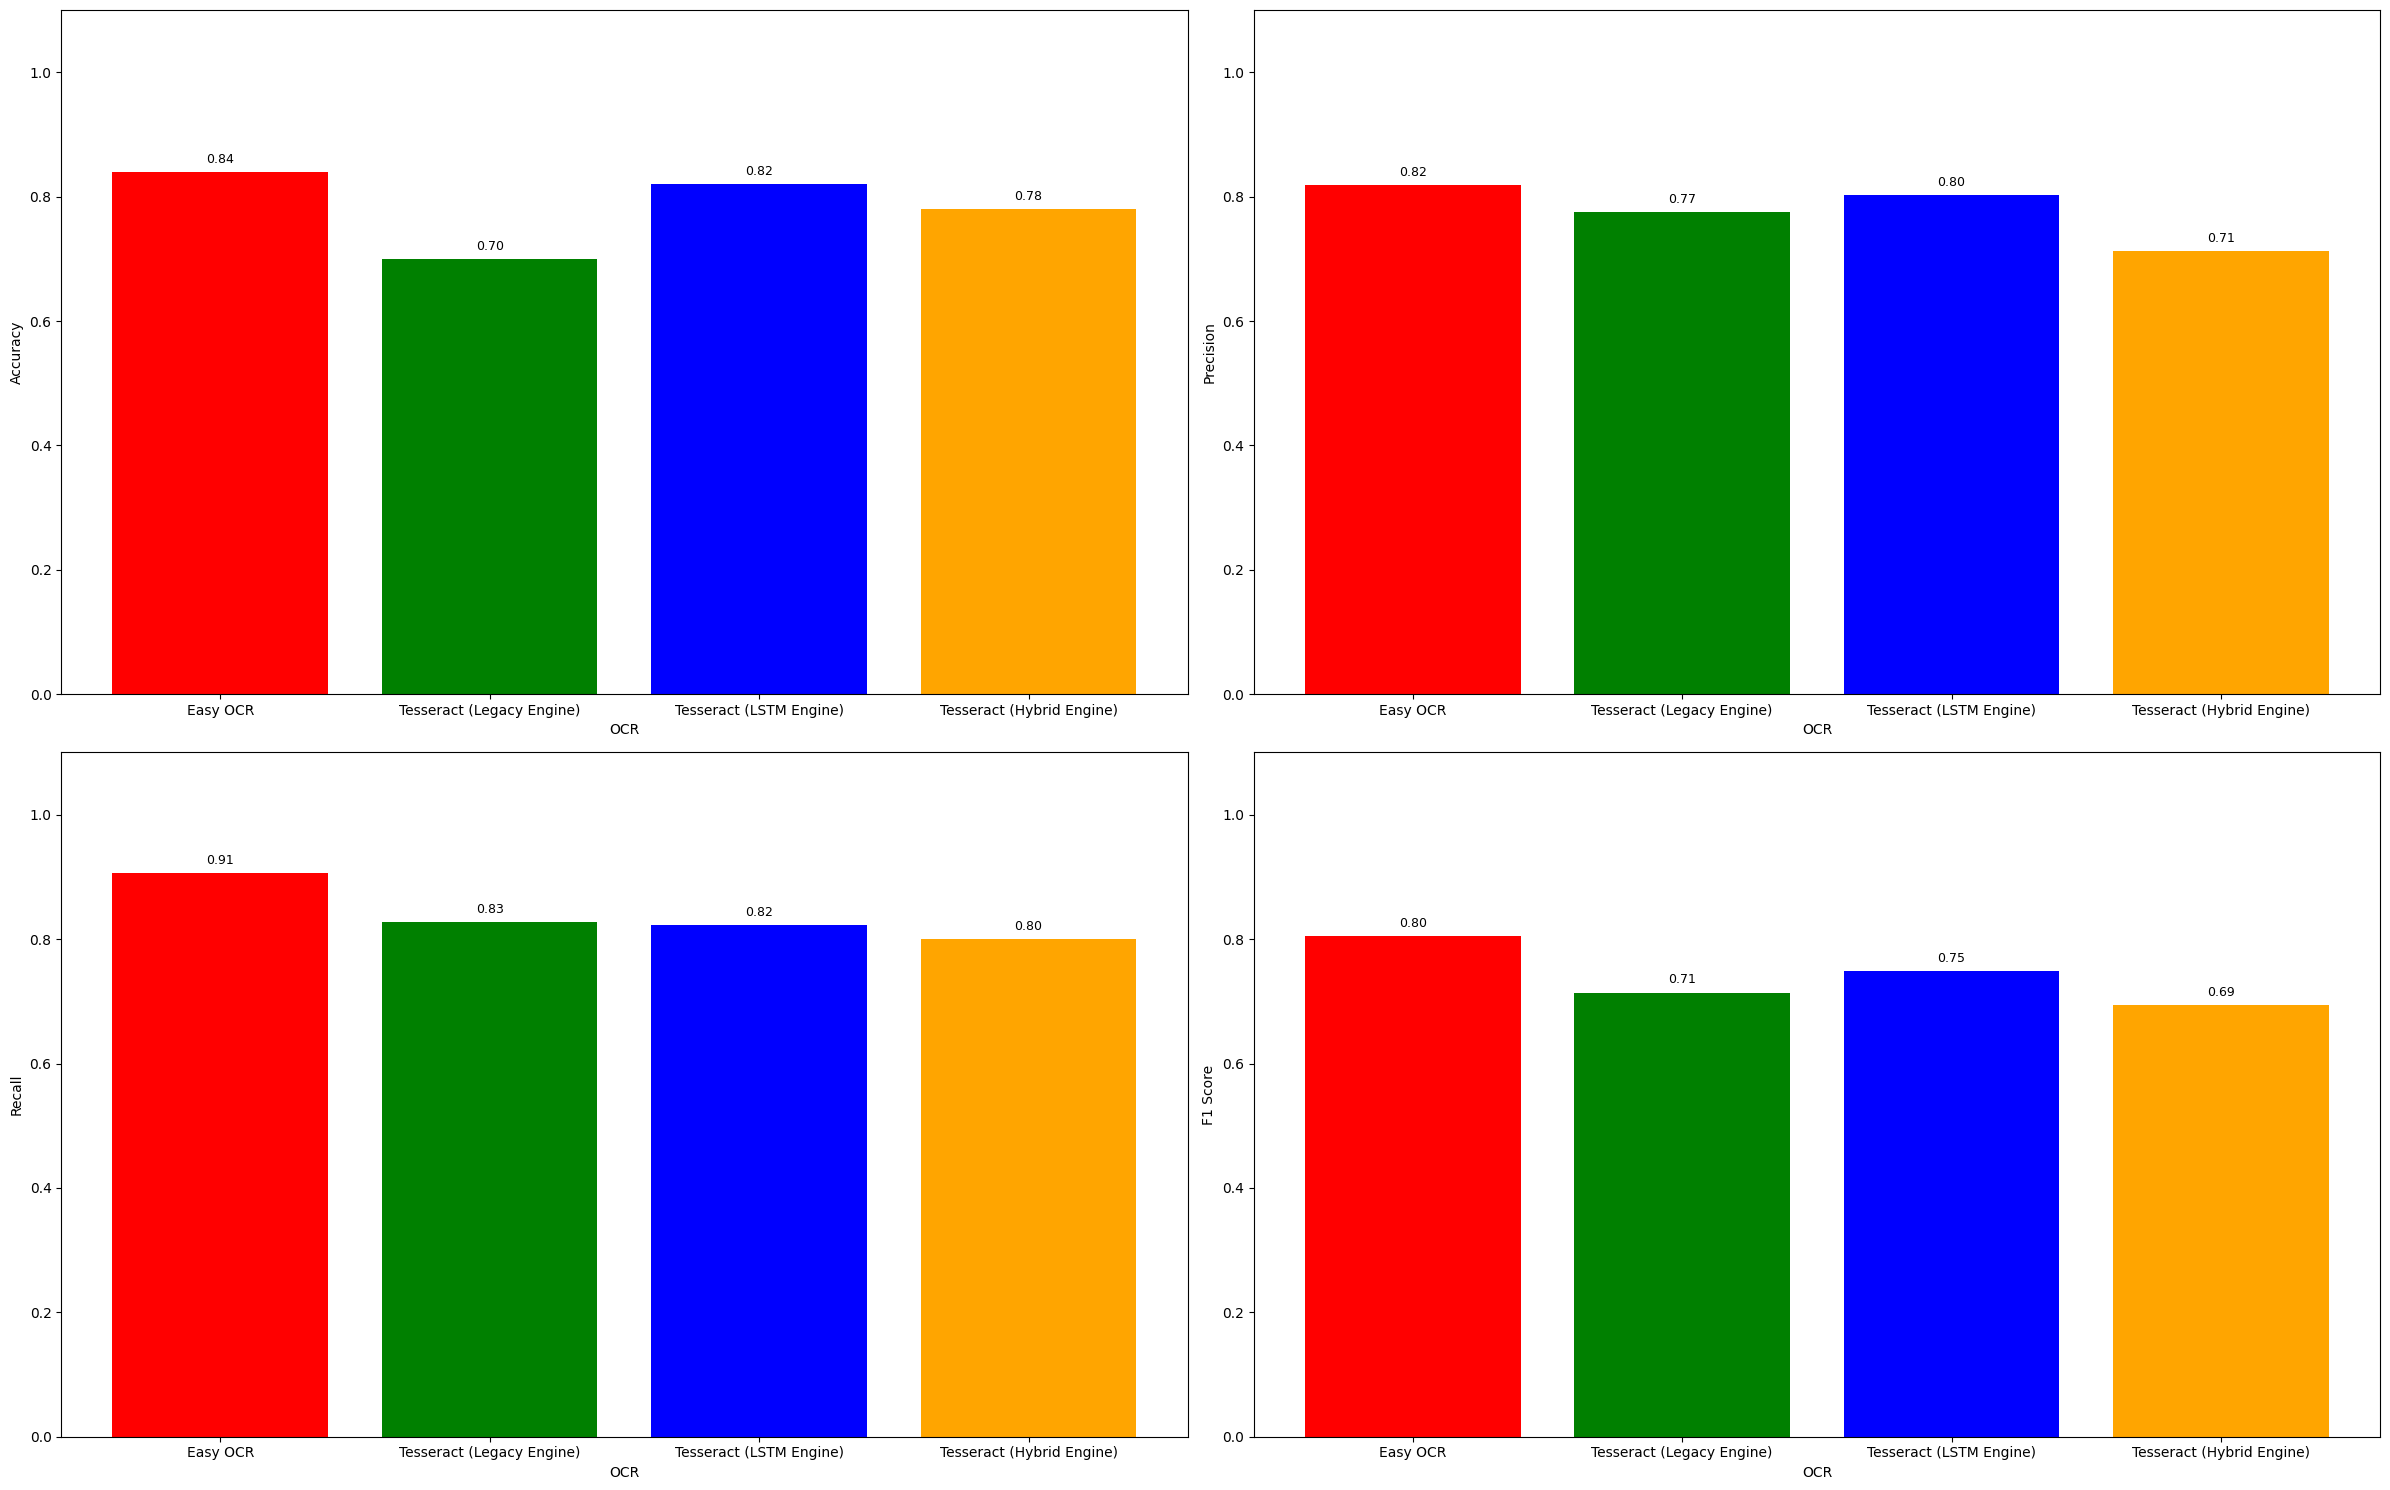

In [15]:
# Alternativa al grafico precedente

fig, axes = plt.subplots(2, 2, figsize=(24,15))
axes = axes.flatten()  # rende più facile iterare

valori = [accuracies, precisions, recalls, f1s]
colors = ['red','green','blue','orange']
metric_name = ['Accuracy','Precision','Recall','F1 Score']
# Plot di ogni istogramma
for i in range(4):
    ax = axes[i]
    y = valori[i]
    bars = ax.bar(index, y, width=0.8, color=colors)

    # Aggiunta etichette sopra le barre
    for b in bars:
        height = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, height + 0.01, f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

    ax.set_ylim(0, 1.1)  # se le metriche sono fra 0 e 1
    ax.set_ylabel(metric_name[i])
    ax.set_xlabel('OCR')

plt.tight_layout()
plt.savefig('plots/metrics_grid.pdf')
plt.show()

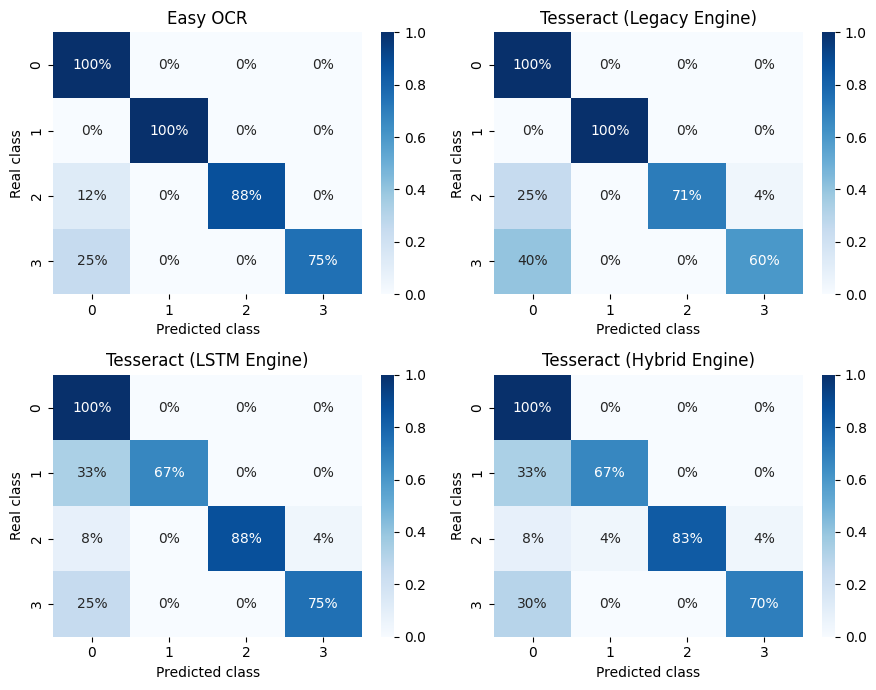

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
matrices = [easy_ocr_cm, pytesseract_legacy_cm, pytesseract_LSTM_cm, pytesseract_hybrid_cm]
norm_matrices = []
for matrix in matrices:
    new_matrix = []
    for row in matrix:
        new_matrix.append(row/np.sum(row))
    norm_matrices.append(new_matrix)
fig, axes = plt.subplots(2, 2, figsize=(9, 7))  # 2 righe, 2 colonne

for i, ax in enumerate(axes.flat): 
    sns.heatmap(norm_matrices[i], annot=True, fmt='.0%', ax=ax, cmap='Blues')
    ax.set_title(f'{index[i]}')
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Real class')

plt.tight_layout()
plt.savefig('plots/confusion_matrices.pdf')
plt.show()